# ERA5 access via the CDS API

The [Climate Data Store](https://cds.climate.copernicus.eu/cdsapp#!/home) run through the [European Center for Medium-Range Weather Forecasts](https://www.ecmwf.int/) provides a great API and associated python package for accessing the eight different ERA5 datasets they host. This notebook will demonstrate using this API to retrieve some of this data.

### Using the CDS API

To use the CDS API, you must [register](https://cds.climate.copernicus.eu/user/register) for API service through the link to the CDS above, and [follow the instructions](https://cds.climate.copernicus.eu/api-how-to) to ensure your credentials properly set up and visible for the python instance. 

## Downloading ERA5 data

The way to submit an API request is with the `retrieve` method of the `cdsapi.api.Client` object. It accepts a dataset name and a dictionary of arguments which can be derived with the help of the "show API request" option on the download form for any of the ERA5 datasets. For example, [here is the form](https://cds.climate.copernicus.eu/cdsapp#!/dataset/reanalysis-era5-single-levels?tab=form) for downloading from the "ERA5 hourly data on single levels from 1940 to present" dataset.

In [44]:
import cdsapi
import xarray as xr
import pandas as pd
from pathlib import Path

Below is an example request for 2m temperature data for 1980-01-01 for a bounding box containing most of Alaska (minus Aleutians west of the antimeridian):

In [15]:
c = cdsapi.Client()

c.retrieve(
    "reanalysis-era5-single-levels",  # name of the dataset
    {  # parameters for the request
        "product_type": "reanalysis",
        "format": "netcdf",
        "variable": "2m_temperature",
        "year": "1980",
        "month": "01",
        "day": "01",
        "time": "00:00",
        "area": [
            72,
            -180,
            50,
            -120,
        ],
    },
    "download.nc",  # download filename
)

2023-11-08 11:03:55,075 INFO Welcome to the CDS
2023-11-08 11:03:55,077 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/reanalysis-era5-single-levels
2023-11-08 11:03:55,428 INFO Request is queued
2023-11-08 11:03:56,646 INFO Request is running
2023-11-08 11:03:58,367 INFO Request is completed
2023-11-08 11:03:58,368 INFO Downloading https://download-0010-clone.copernicus-climate.eu/cache-compute-0010/cache/data5/adaptor.mars.internal-1699473837.2893562-14133-18-faab0232-315d-449f-8043-6ad37e1f07e3.nc to download.nc (44.2K)
2023-11-08 11:04:00,481 INFO Download rate 20.9K/s  


Result(content_length=45300,content_type=application/x-netcdf,location=https://download-0010-clone.copernicus-climate.eu/cache-compute-0010/cache/data5/adaptor.mars.internal-1699473837.2893562-14133-18-faab0232-315d-449f-8043-6ad37e1f07e3.nc)

This downloads the data to a file called `download.nc` in the current working directory:

In [21]:
ds = xr.open_dataset("download.nc")
ds

<xarray.Dataset>
Dimensions:    (longitude: 241, latitude: 89, time: 1)
Coordinates:
  * longitude  (longitude) float32 -180.0 -179.8 -179.5 ... -120.5 -120.2 -120.0
  * latitude   (latitude) float32 72.0 71.75 71.5 71.25 ... 50.5 50.25 50.0
  * time       (time) datetime64[ns] 1980-01-01
Data variables:
    t2m        (time, latitude, longitude) float32 ...
Attributes:
    Conventions:  CF-1.6
    history:      2023-11-08 20:03:57 GMT by grib_to_netcdf-2.25.1: /opt/ecmw...

Have a look at this data:

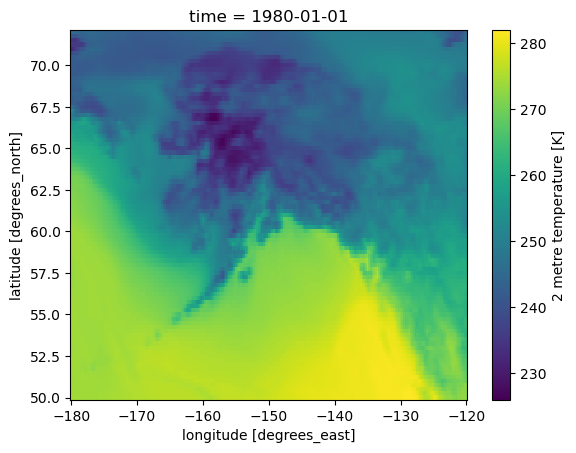

In [22]:
ds["t2m"].plot()

#### Target download directory

Note, this tool currently just writes the downloaded data to a specified file name. So you may want to set up a path for a directory for writing these files. E.g.:

In [26]:
era5_dir = Path("./ERA5_data")
era5_dir.mkdir(exist_ok=True)

#### Download with multiple dates and times

If we want to get downloads for multiple dates and or times, we simply supply a list of the different temporal values we are seeking. For example, here is a request for 2m temperature at noon on January 1 for each year in 1980-2009:

In [32]:
download_path = era5_dir.joinpath("t2m_Jan1noon_1980-2009.nc")
ak_bbox = [72, -180, 50, -120]
params = {
    "product_type": "reanalysis",
    "format": "netcdf",
    "variable": "2m_temperature",
    "year": [str(year) for year in range(1980, 2010)],
    "month": "01",
    "day": "01",
    "time": "12:00",
    "area": ak_bbox,
}
c.retrieve("reanalysis-era5-single-levels", params, download_path)

2023-11-08 11:43:15,674 INFO Welcome to the CDS
2023-11-08 11:43:15,675 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/reanalysis-era5-single-levels
2023-11-08 11:43:15,976 INFO Request is queued
2023-11-08 11:43:17,232 INFO Request is running
2023-11-08 11:43:30,391 INFO Request is completed
2023-11-08 11:43:30,393 INFO Downloading https://download-0016.copernicus-climate.eu/cache-compute-0016/cache/data6/adaptor.mars.internal-1699476206.792085-3661-7-60ed6bbe-60e9-413d-9b5b-87a5973819cf.nc to ERA5_data/t2m_Jan1noon_1980-2009.nc (1.2M)
2023-11-08 11:43:34,022 INFO Download rate 347K/s   


Result(content_length=1289452,content_type=application/x-netcdf,location=https://download-0016.copernicus-climate.eu/cache-compute-0016/cache/data6/adaptor.mars.internal-1699476206.792085-3661-7-60ed6bbe-60e9-413d-9b5b-87a5973819cf.nc)

We can verify that the file has the expected datetimes:

In [37]:
ds = xr.open_dataset(download_path)
ds.time.values

array(['1980-01-01T12:00:00.000000000', '1981-01-01T12:00:00.000000000',
       '1982-01-01T12:00:00.000000000', '1983-01-01T12:00:00.000000000',
       '1984-01-01T12:00:00.000000000', '1985-01-01T12:00:00.000000000',
       '1986-01-01T12:00:00.000000000', '1987-01-01T12:00:00.000000000',
       '1988-01-01T12:00:00.000000000', '1989-01-01T12:00:00.000000000',
       '1990-01-01T12:00:00.000000000', '1991-01-01T12:00:00.000000000',
       '1992-01-01T12:00:00.000000000', '1993-01-01T12:00:00.000000000',
       '1994-01-01T12:00:00.000000000', '1995-01-01T12:00:00.000000000',
       '1996-01-01T12:00:00.000000000', '1997-01-01T12:00:00.000000000',
       '1998-01-01T12:00:00.000000000', '1999-01-01T12:00:00.000000000',
       '2000-01-01T12:00:00.000000000', '2001-01-01T12:00:00.000000000',
       '2002-01-01T12:00:00.000000000', '2003-01-01T12:00:00.000000000',
       '2004-01-01T12:00:00.000000000', '2005-01-01T12:00:00.000000000',
       '2006-01-01T12:00:00.000000000', '2007-01-01

And so we can compute a climatology for January 1st from this data:

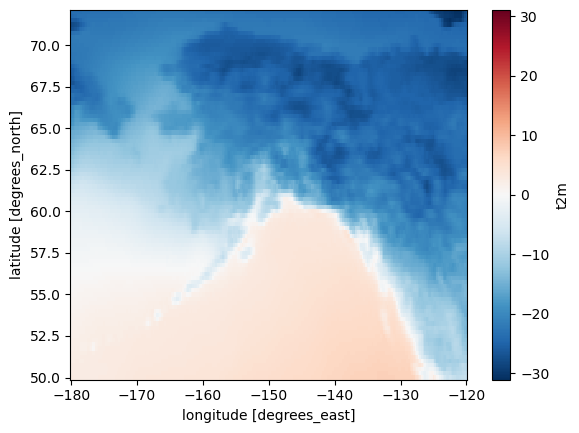

In [43]:
# converted to Celsius
(ds["t2m"].mean(dim="time") - 273.15).plot()

#### Downloading all data withing temporal range

Given that the format required for the API utilizes discrete time values, there is not a great way to request "all data within a given time range". Here is a trick to do so programmatically with python, using `pandas`: create a `DatetimeIndex` using the `date_range` function, and parse out the different values for each time unit:

In [70]:
date_range = pd.date_range("1980-01-01", "1980-01-31", freq="1h")
time_params = {
    "time": date_range.strftime("%H:%M").unique().to_list(),
    "year": date_range.strftime("%Y").unique().to_list(),
    "month": date_range.strftime("%m").unique().to_list(),
    "day": date_range.strftime("%d").unique().to_list(),
}

Then merge these in with the other required parameters:

In [71]:
download_path = era5_dir.joinpath("t2m_1980.nc")

ak_bbox = [72, -180, 50, -120]
params = {
    "product_type": "reanalysis",
    "format": "netcdf",
    "variable": "2m_temperature",
    "area": ak_bbox,
}
params.update(time_params)
c.retrieve("reanalysis-era5-single-levels", params, download_path)

2023-11-08 12:17:28,254 INFO Welcome to the CDS
2023-11-08 12:17:28,255 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/reanalysis-era5-single-levels
2023-11-08 12:17:50,845 INFO Request is running
2023-11-08 12:18:45,618 INFO Request is completed
2023-11-08 12:18:45,620 INFO Downloading https://download-0005-clone.copernicus-climate.eu/cache-compute-0005/cache/data1/adaptor.mars.internal-1699478307.656129-980-16-c5db8848-cec9-4f32-bc2b-c3309d6f9871.nc to ERA5_data/t2m_1980.nc (30.4M)
2023-11-08 12:18:59,000 INFO Download rate 2.3M/s   


Result(content_length=31921476,content_type=application/x-netcdf,location=https://download-0005-clone.copernicus-climate.eu/cache-compute-0005/cache/data1/adaptor.mars.internal-1699478307.656129-980-16-c5db8848-cec9-4f32-bc2b-c3309d6f9871.nc)

And verify the times of the downloaded file:

In [79]:
ds = xr.open_dataset(download_path)
print(ds.time.values[:10], end="\n\n")
print(ds.time.values[-10:])

['1980-01-01T00:00:00.000000000' '1980-01-01T01:00:00.000000000'
 '1980-01-01T02:00:00.000000000' '1980-01-01T03:00:00.000000000'
 '1980-01-01T04:00:00.000000000' '1980-01-01T05:00:00.000000000'
 '1980-01-01T06:00:00.000000000' '1980-01-01T07:00:00.000000000'
 '1980-01-01T08:00:00.000000000' '1980-01-01T09:00:00.000000000']

['1980-01-31T14:00:00.000000000' '1980-01-31T15:00:00.000000000'
 '1980-01-31T16:00:00.000000000' '1980-01-31T17:00:00.000000000'
 '1980-01-31T18:00:00.000000000' '1980-01-31T19:00:00.000000000'
 '1980-01-31T20:00:00.000000000' '1980-01-31T21:00:00.000000000'
 '1980-01-31T22:00:00.000000000' '1980-01-31T23:00:00.000000000']
